## **Limpieza de datos**

In [74]:
!pip install tabula-py
!pip install pypdf
!pip install geopandas
!pip install googletrans
!pip install plotly

^C


In [1]:
import pandas as pd
import tabula
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from ipywidgets import interact, widgets
import matplotlib.patches as mpatches
import geopandas as gpd
import plotly.express as px

### **Funciones**

In [2]:
def remove_stretch(value):
    """
    Función que toma un valor como entrada y verifica si está en una lista predefinida llamada blocked. Si el valor está en la lista, 
    devuelve np.nan. Si el valor es una cadena, divide la cadena por "\r" y devuelve la última parte después de la división. Si el valor 
    no está en la lista ni es una cadena, lo devuelve sin cambios.
    """
    bloqued = ["Stretch 1","Stretch 2","Stretch 3","Stretch 4","Stretch 5","Stretch 6","Stretch 7","Stretch 8","Stretch 9"]
    if value in bloqued:
        return np.nan
    elif isinstance(value, str):
        parts = value.split("\r") # Dividir el valor por "\r" y eliminar la parte antes de la barra
        return parts[-1]  # Tomar la última parte después de dividir por "\r"


    else:
        return value
    
def get_best_lap_and_speed(pilot_name,concated_dataframes):
    """ 
    Función que encuentra el índice del mejor tiempo de vuelta (best_lap) y la mejor velocidad (best_speed) para un 
    piloto específico en un conjunto de datos concatenados. Luego, obtiene las filas correspondientes a esos índices 
    y las concatena horizontalmente en un DataFrame, que luego devuelve.
    """
    best_speed = concated_dataframes[pilot_name][concated_dataframes[pilot_name]["T/S"] == "S"]['Total'].idxmax()
    best_lap = concated_dataframes[pilot_name][concated_dataframes[pilot_name]["T/S"] == "T"]['Total'].idxmin()

    lap_row = concated_dataframes[pilot_name].loc[best_lap]
    speed_row = concated_dataframes[pilot_name].loc[best_speed]

    return pd.concat([lap_row, speed_row], axis=1)

def gradiente_rgb(valor, promedio, desviacion):
    """
    Función que ubica un valor determinado, dentro de una gaussiana
    A partir de su ubicación, le confiere un color que va desde rojo (menor que el promedio) amarillo (promedio) verde (por arriba del promedio)
    y devuelve una terna (r, g, b) con los valores rgb correspondientes.
    Rojo es (255,0,0)
    Amarillo es (255,255,0)
    Verde es (0,255,0)
    """
    z = round(((valor - promedio) / desviacion), 4) # Normalizamos el valor
    def color_rgb(z):
        if z == 0:
            r = 255
            g = 255
            b = 0
        elif z < 0:
            g = 255
            r = 255 + (z*255)*2
            if r <= 0:
                r = 0
            b = 0
        elif z > 0:
            g = 255 - (z*255)*2
            if g <= 0:
                g = 0
            r = 255
            b = 0
        else:
            r = 0
            g = 0
            b = 0
        return (r, g, b)

        
    return color_rgb(z) # Devolvemos el color RGB correspondiente al valor normalizado

def rellenar_contorno(contorno, color, img_contorno):
    """  
    Función que toma un contorno, un color y una imagen como entrada. Aproxima el contorno a un polígono, lo 
    convierte en un conjunto de puntos y rellena el polígono con el color especificado en la imagen.
    """
    aproximacion = cv2.approxPolyDP(contorno, 4, True) # Aproximar el contorno a una aproximación de polígono
    puntos = aproximacion.reshape((-1, 1, 2)) # Convertir la aproximación a un array de puntos
    cv2.fillPoly(img_contorno, [puntos], color) # Rellenar el polígono con el color especificado

def mapa_piloto_global(concated_dataframes,pilot_name, diccionario_curvas_indices, 
                       mean_global_time = None, std_global_time = None, img_contorno = None, contornos = None, cont = True):
    """  
    Función que genera un mapa de tiempos promedio de un piloto específico en una serie de curvas. Utiliza un 
    diccionario que asigna índices de curvas a nombres de curvas, así como tiempos promedio globales y desviaciones 
    estándar globales para calcular y representar los tiempos promedio del piloto en cada curva. Opcionalmente, puede 
    rellenar los contornos de las curvas en una imagen dada con colores que representan los tiempos promedio.
    """
    pilot_times = {}
    for curva, key in diccionario_curvas_indices.items():
        mean_pilot_time = concated_dataframes[pilot_name][curva][concated_dataframes[pilot_name]["T/S"] == "T"].mean()
        pilot_times[curva] = mean_pilot_time
        
        if cont == True:
            rellenar_contorno(contornos[key], gradiente_rgb(mean_pilot_time, mean_global_time[curva], std_global_time[curva]), img_contorno)

    return pilot_times

def grafica_curva(data):
    """  
    Función que crea una gráfica de barras y una línea para visualizar los cambios relativos acumulados en los datos 
    dados. Calcula la suma acumulada de una columna específica en los datos y crea un gráfico de barras para mostrar 
    la columna original y un gráfico de líneas para mostrar la suma acumulada.
    """
    data['dT Relativo segmento a segmento Acumulado (%)'] = data['dT Relativo segmento a segmento (%)'].cumsum() # Calcula la suma acumulada de la columna 'dT Relativo (%)' y la asigna a una nueva columna 'dT Relativo Acumulado (%)'
    fig, ax = plt.subplots() # Crea una figura y un eje para el gráfico
    
    # Calcula los límites para el eje y de acuerdo con los datos
    max_y = max(data['dT Relativo segmento a segmento Acumulado (%)'].max(), data['dT Relativo segmento a segmento (%)'].max())
    min_y = min(data['dT Relativo segmento a segmento Acumulado (%)'].min(), data['dT Relativo segmento a segmento (%)'].min())
    ax.set_ylim(min_y - 1, max_y + 1) # Establece los límites del eje y del primer eje (para el gráfico de barras)

    # Crea un gráfico de barras para mostrar los datos de 'dT Relativo (%)' en función de 'Curva'
    sns.barplot(x='Curva', y='dT Relativo segmento a segmento (%)', data=data, ax=ax, palette='dark:blue', hue="Curva")
    plt.xticks(rotation=90)
    plt.yticks(rotation=45)
    # Crea un segundo eje y para el gráfico de líneas
    ax2 = ax.twinx()
    ax2.set_ylim(min_y - 1, max_y + 1)
    sns.lineplot(x='Curva', y='dT Relativo segmento a segmento Acumulado (%)', data=data, ax=ax2, sort=False, color='r')
    plt.xticks(rotation=45)
    ax.grid(True)
    plt.show()

def graficar_correlacion(mean_global_time, pilot_names, resul_race, concated_dataframes, diccionario_curvas_indices):
    lista_posiciones = []
    total_time_mean = sum(list(mean_global_time.values()))
    for piloto in pilot_names:
        posicion = list(resul_race["Pos"][resul_race["Driver"] == piloto])
        #diccionario_posicion[piloto] = int(posicion[0])
        pilot_times = sum(list(mapa_piloto_global(concated_dataframes, piloto, diccionario_curvas_indices, cont=False).values()))
        dt_total = total_time_mean - pilot_times
        dt_calculado = (dt_total / total_time_mean) * 100
        lista_posiciones.append((int(posicion[0]), dt_calculado))
    lista_posiciones.sort(key=lambda x: x[0])
    x_values, y_values = zip(*lista_posiciones)
    dataframe_correlacion = pd.DataFrame({'Posicion': x_values, 'dT Total relativo (%)': y_values})
    
    sns.lmplot(x="Posicion", y="dT Total relativo (%)", data=dataframe_correlacion, ci=None)
    plt.xticks(range(1, len(x_values) + 1), x_values, fontsize=6) # Establece los ticks del eje x
    plt.grid(True)

## **Carga de datos**

In [3]:
directorio_data = "bbdd"
file_path = directorio_data + "/indycar-sectionresults-race.pdf"
dataframes = {}
total_pages = 260
for page in tqdm(range(1, total_pages + 1), desc="Leyendo páginas"):
    try:
        # Leer las tablas de la página actual
        dfs = tabula.read_pdf(file_path, pages=page, multiple_tables=True)
        # Obtener la tabla de la segunda posición (dfs[1])
        if dfs:
            pagina = 0
            df = dfs[1]
            key = df.columns[0]

            key = key.strip().replace(" ", "_").replace("/", "_").replace("-", "_")
            key = re.sub(r'Section_Data_for_Car_\d+___', '', key)
            key = key.replace(",_",",").replace("_","")

            original_key = key
            key = key+"_page_0"
            # Verificar si la clave ya existe en dataframes
            while key in dataframes:
                pagina += 1
                key = f"{original_key}_page_{pagina}"  # Generar una nueva clave con el número de página
            dataframes[key] = df  # Guardar el DataFrame en el diccionario con la clave correspondiente


            pagina = 1 # Reiniciar contador de pagina

    except Exception as e:
        print(f"Error al procesar la página {page}: {e}")
        
resul_race = pd.read_excel('bbdd/indycar-race-results.xlsx',sheet_name=2)
conductores = pd.read_excel('bbdd/datos conductores.xlsx')
resul_race["Driver"] = resul_race["Driver"].str.replace(" ","")
conductores["Conductores"] = conductores["Conductores"].str.replace(" ","")
for key, df in dataframes.items():
    if len(df.columns) < 11:
        dataframes[key]["PI to PO"] = np.nan
        dataframes[key]["PO to SF"] = np.nan
        dataframes[key]["SF to PI"] = np.nan
        
# Iterar sobre cada DataFrame en el diccionario
for key, data in dataframes.items():
    try:
        data_drop = data.drop(0) # Eliminar la segunda fila
    except:
        print("Failed Drop")
    cant_columnas = int(len(dataframes[key].columns))
    
    if cant_columnas == 11:
        column_names = [
            "Lap", "T/S", "Turn 9", "Turn 10", "Hairpin", "Front 5",
            "Front 6", "Total", "PI to PO","PO to SF", "SF to PI"
        ]
    elif cant_columnas == 17:
        column_names = [
            "Lap", "T/S", "Front 1", "Front 2", "Front 3",
            "Front 4", "Turn 1", "Turn 2", "Turn 3", "Turn 4", "Turn 5",
            "Turn 5A", "Turns 6/7", "Turn 7A", "Turn 8", "Back Stretch 1",
            "Back Stretch 2"
        ]
    else:
        print("Error cant columnas")
    data_drop.columns = column_names # Cambiar los nombres de las columnas

    # Aplicar la función a cada celda del DataFrame
    last_row = data_drop.iloc[-1].dropna().tolist()
    last_row = [np.nan] + last_row
    if len(last_row) < len(data_drop.columns):
        last_row += [None] * (len(data_drop.columns) - len(last_row))
    data_drop.iloc[-1] = last_row
    data_cleaned = data_drop.applymap(remove_stretch)
    cant_columnas = int(len(data_cleaned.columns))

    if cant_columnas == 11:
        column_float = [
            "Lap", "Turn 9", "Turn 10", "Hairpin", "Front 5",
            "Front 6", "Total", "PI to PO", "PO to SF", "SF to PI"
        ]
        column_str = ["T/S"]
    elif cant_columnas == 17:
        column_float = [
            "Lap", "Front 1", "Front 2", "Front 3",
            "Front 4", "Turn 1", "Turn 2", "Turn 3", "Turn 4", "Turn 5",
            "Turn 5A", "Turns 6/7", "Turn 7A", "Turn 8", "Back Stretch 1",
            "Back Stretch 2"
        ]
        column_str = ["T/S"]
    data_cleaned[column_float] = data_cleaned[column_float].astype(float)
    data_cleaned[column_str] = data_cleaned[column_str].astype(str)
    dataframes[key] = data_cleaned # Guardar el DataFrame limpio de vuelta en el diccionario
    
for key, data in dataframes.items():
    data['Lap'].fillna(method='ffill', inplace=True) # Rellena los valores faltantes en la columna 'Lap' utilizando el método de relleno hacia adelante
    
combined_dataframes = {} # Crear un nuevo diccionario para los DataFrames combinados
keys = sorted(dataframes.keys()) # Crear una lista de las claves ordenadas
n = 0
i = 0
while i < len(keys):
    key1 = keys[i]
    # Si hay un siguiente elemento y su clave contiene "page"
    if (i + 1 < len(keys)) and re.search(r'page', keys[i + 1]):
        if key1[-1] == "0":
            n = 0
        key2 = keys[i + 1]
        if key1[:-7] == key2[:-7]:
        # Realizar el merge usando las columnas "Lap" y "T/S"
            combined_key = f"{key1[:-7]}_{n}"
            n += 1
            combined_dataframes[combined_key] = pd.merge(dataframes[key1], dataframes[key2], on=["Lap", "T/S"])
        else:
            combined_dataframes[f"{key1[:-7]}_{n}"] = dataframes[key1]
            i += 1
            continue
        i += 2  # Saltar al siguiente par
    else:
        i += 1  # Si no hay "page" en la siguiente clave, solo incrementar
        
lista_concatenado = []
concated_dataframes = {}
pilotos = set()
for key in combined_dataframes:
    pilotos.add(key[:-2])
for name in pilotos:
    for key, df in combined_dataframes.items():
        if key[:-2] == name:
            lista_concatenado.append(df)
    concated_dataframes[name] = pd.concat(lista_concatenado, ignore_index=True)
    lista_concatenado = []

Leyendo páginas:   0%|          | 0/260 [00:00<?, ?it/s]

Leyendo páginas: 100%|██████████| 260/260 [00:26<00:00,  9.68it/s]
C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\3682290116.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60.391' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_drop.iloc[-1] = last_row
C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\3682290116.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_cleaned = data_drop.applymap(remove_stretch)
C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\3682290116.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.506' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_drop.iloc[-1] = last_row
C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\3682290116.py:72: FutureWarning

In [23]:
resul_race

,Pos,SP,Car,Driver,C/E/T,Lap,Laps\nDown,Time\nDown,Pit\nStops,Elapsed Time,Avg\nSpeed,Running /\nReason Out,Pts,Total\nPts,Standings
0,1,8,9,"Dixon,Scott",D/H/F,85,0,--.----,2,01:42:03.1416,98.350,Running,53,75,2
1,2,4,26,"Herta,Colton",D/H/F,85,0,0.9798,2,01:42:04.1214,98.334,Running,41,72,3
2,3,6,10,"Palou,Alex",D/H/F,85,0,1.7664,2,01:42:04.9080,98.321,Running,35,63,4
3,4,3,2,"Newgarden,Josef",D/C/F,85,0,3.9735,2,01:42:07.1151,98.286,Running,33,87,1
4,5,5,28,"Ericsson,Marcus",D/H/F,85,0,4.3769,2,01:42:07.5185,98.279,Running,30,35,12
5,6,2,12,"Power,Will",D/C/F,85,0,15.7639,2,01:42:18.9055,98.097,Running,29,61,5
6,7,10,27,"Kirkwood,Kyle",D/H/F,85,0,16.1788,2,01:42:19.3204,98.090,Running,27,45,8
7,8,16,77,"Grosjean,Romain",D/C/F,85,0,18.0433,2,01:42:21.1849,98.061,Running,24,30,13
8,9,1,60,"Rosenqvist,Felix",D/H/F,85,0,18.8155,2,01:42:21.9571,98.048,Running,24,50,7
9,10,13,7,"Rossi,Alexander",D/C/F,85,0,32.0915,3,01:42:35.2331,97.837,Running,20,44,9


In [71]:
concated_dataframes["Power,Will"]

,Lap,T/S,Front 1,Front 2,Front 3,Front 4,Turn 1,Turn 2,Turn 3,Turn 4,...,Back Stretch 2,Turn 9,Turn 10,Hairpin,Front 5,Front 6,Total,PI to PO,PO to SF,SF to PI
0,1.0,T,2.9628,5.0007,3.0152,3.9908,4.2239,4.1065,4.7432,5.5594,...,5.2685,13.0962,9.3397,7.9176,3.4141,5.7534,118.2917,NaN,NaN,NaN
1,1.0,S,109.0800,92.3050,109.4460,97.3830,60.2090,54.6250,58.9360,50.6510,...,60.1770,44.2530,30.0770,27.0400,36.1470,102.8640,59.8930,NaN,NaN,NaN
2,2.0,T,2.1012,2.8105,1.9297,2.4661,3.9646,2.7005,4.0036,3.3444,...,2.0211,5.8765,3.3135,4.5642,1.5296,4.6739,69.9347,NaN,NaN,NaN
3,2.0,S,153.8090,164.2380,171.0120,157.5910,64.1470,83.0650,69.8240,84.1970,...,156.8670,98.6210,84.7780,46.9070,80.6800,126.6220,101.3060,NaN,NaN,NaN
4,3.0,T,2.0435,2.8282,1.9637,2.5315,3.5864,2.6616,3.9582,3.2539,...,2.0168,5.7784,3.2724,4.5652,1.5182,4.6722,68.8017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,84.0,S,159.9840,165.7180,168.3770,144.2490,70.0250,83.8220,71.4220,86.7520,...,158.9600,100.8030,83.1890,46.5600,81.2910,127.7590,102.9740,NaN,NaN,NaN
168,85.0,T,2.0171,2.7913,1.9384,2.6259,4.2115,2.7767,4.0183,3.3315,...,2.0016,5.9112,3.3035,4.5837,1.5054,4.6211,69.7295,NaN,NaN,NaN
169,85.0,S,160.2220,165.3680,170.2440,148.0000,60.3870,80.7850,69.5690,84.5230,...,158.3960,98.0420,85.0350,46.7070,81.9770,128.0690,101.6040,NaN,NaN,NaN
170,86.0,T,2.0235,3.0415,2.5895,3.7797,4.5399,3.7691,5.2439,4.5971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pilot_names = concated_dataframes.keys()  # Obtener los nombres de los pilotos

@interact(pilot=widgets.Dropdown(options=pilot_names, description='Pilot:'))
def show_best_lap_and_speed(pilot):
    result = get_best_lap_and_speed(pilot,concated_dataframes)
    display(result)

interactive(children=(Dropdown(description='Pilot:', options=('Palou,Alex', 'Dixon,Scott', 'Herta,Colton', 'Fe…

## **Graficos**

### **¿Existe una correlacion entre el rendimiento puro del piloto y su resultado?**

In [4]:
pilot_names = concated_dataframes.keys()  # Obtener los nombres de los pilotos
full_dataframe = pd.concat(concated_dataframes)
mapa_circuito = cv2.imread("bbdd/Pista.png")
labels_pista = cv2.imread("bbdd/PistaLabel2.png", cv2.IMREAD_UNCHANGED)
lista_curvas = list(full_dataframe.columns.values)[2:]
lista_curvas.remove("Total")
Indices_Ordenados = [2, 3, 5, 9, 10, 7, 8, 15, 19, 16, 12, 20, 22, 24, 23, 21, 18, 17, 14, 11, 13, 4, 6]
diccionario_curvas_indices = dict(zip(lista_curvas, Indices_Ordenados))
mean_global_time = dict(full_dataframe[lista_curvas][full_dataframe["T/S"] == "T"].mean())
std_global_time = dict(full_dataframe[lista_curvas][full_dataframe["T/S"] == "T"].std())
imagen_gris = cv2.cvtColor(mapa_circuito, cv2.COLOR_BGR2GRAY)
bordes = cv2.Canny(imagen_gris, 50, 150)
contornos, _ = cv2.findContours(bordes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

@interact(pilot=widgets.Dropdown(options=pilot_names, description='Piloto:'))
def show_mapa_piloto_global(pilot):
    img_contorno = np.ones_like(mapa_circuito) * 255
    cv2.drawContours(img_contorno, contornos, -1, (0, 0, 0), 3)
    pilot_times = mapa_piloto_global(concated_dataframes,pilot, diccionario_curvas_indices, mean_global_time, std_global_time, img_contorno, contornos)
    
    # Crear el DataFrame para la tabla
    data_tiempos_sector = {
        'Curva': lista_curvas,
        'Media Global (s)': [round(mean_global_time[curva],4) for curva in lista_curvas],
        'Media Piloto (s)': [round(pilot_times[curva],4) for curva in lista_curvas],
        'dT Relativo segmento a segmento (%)': [round((mean_global_time[curva] - pilot_times[curva])* (100/mean_global_time[curva]),3) for curva in lista_curvas]
    }
    # Para cada segmento:
    

    
    tiempos_sector_dataframe = pd.DataFrame(data_tiempos_sector)
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    plt.axis('off')

    # Añadir la leyenda
    above_mean_patch = mpatches.Patch(color='green', label='Verde = Mayor desviacion positiva respecto a la media')
    average_patch = mpatches.Patch(color='yellow', label='Amarillo = Desviacion cercana a 0 respecto a la media')
    below_mean_patch = mpatches.Patch(color='red', label='Rojo = Mayor desviacion negativa respecto a la media')
    plt.legend(handles=[above_mean_patch, average_patch, below_mean_patch], loc='upper right', fontsize=6)

    # Mostrar la imagen del contorno
    ax.imshow(img_contorno, cmap='viridis', interpolation='bilinear', vmin=0, vmax=1, origin='upper')
    ax.imshow(labels_pista, cmap='viridis', interpolation='bilinear', vmin=0, vmax=1, origin='upper')

    # Añadir la tabla
    table = plt.table(cellText=tiempos_sector_dataframe.values, colLabels=tiempos_sector_dataframe.columns, cellLoc='center', loc='bottom', bbox=[1, 0, 0.5, 0.85])
    table.auto_set_font_size(True)
    table.set_fontsize(7)
    table.auto_set_column_width([0, 1, 2, 3])

    plt.show()
    grafica_curva(tiempos_sector_dataframe)
    graficar_correlacion(mean_global_time,pilot_names,resul_race,concated_dataframes,diccionario_curvas_indices)

interactive(children=(Dropdown(description='Piloto:', options=('Kirkwood,Kyle', 'Robb,StingRay', 'Rahal,Graham…

**3 Graficas y 1 Tabla**

**Explicacion grafica Pista de carrera:**
- En la pista de carrera, lo que podemos ver es un diagrama de color que nos indica a cuantas desviaciones estandar se encuentra de la media el tiempo que tardo un piloto en recorrer un segmento. Es decir, Un color rojo nos da magnitud de cuantas desviaciones estandar se desvia del valor de la media de manera que el corredor tardo mas tiempo en recorrer ese segmento. Amarillo nos indicaria que tuvo muy pocas desviaciones estandar con respecto a la media, y un color verde nos indica que tuvo muchas desviaciones estandar que se desvia de la media de manera que tardo menor tiempo en recorrer ese segmento.

- Esto se debe a que, para el color se utilizo el **Promedio** de todos los pilotos, junto con su **Desviacion Estandar**, y se calculo el z con respecto al valor medio de tiempo de conductor (SEGMENTO A SEGMENTO)

- Esto nos da dimension de que tan bueno fue el corredor en los distintos segmentos con respecto al resto de corredores.

**Explicacion de la Tabla de Valores:**
- En la tabla de valores tenemos "Segmento" los valores de "Tiempo promedio de ese segmento", "Tiempo del piloto en ese segmento",  "Delta relativo al tiempo promedio"

- El Delta de tiempo piloto relativo al tiempo promedio (PORCENTUAL), es la diferencia entre "el tiempo promedio del segmento y el tiempo del piloto en ese segmento" dividido el "tiempo promedio del segmento", y finalmente multiplicado por 100. (Tambien es un valor Segmento a Segmento)


**Explicacion grafica de dT relativo porcentual:**
- En esta grafica, tenemos segmento a segmento la ganancia y perdida porcentual que tuvo el piloto (el delta de tiempo piloto relativo al tiempo promedio (porcentual), en cada segmento de la pista. Y a su vez el porcentaje acumulado a lo largo de la pista.

- Esta grafica nos da dimension sobre en que segmentos el piloto obtuvo ganancias con respecto al valor promedio, y podria dar una idea de en que segmentos el piloto deberia profundizar sus practicas para asi mejorar su desempeño.

- Como los segmentos de la pista no poseen la misma distancia, y cada uno consume distintos tiempos, la ganancia acumulada de la grafica es distinto a realizar, el mismo tipo de formula pero aplicada a la suma de los tiempos de los segmentos.

Por esta razon decidimos analizar este valor, que no sea segmento a segmento y que sea de toda la pista en si, para esto Sumamos todos los valores de tiempo del piloto de cada segmento (para obtener el tiempo total de vuelta promedio) y todos los valores de tiempo promedio (para obtener el tiempo total promedio de vuelta) como otro criterio de buen desempeño sobre vueltas.

Luego optamos por realizar un grafico de correlacion lineal, de la posicion de cada piloto y este valor obtenido.

**Explicacion grafica de dT Total porcentual:**

Claramente se puede ver en la grafica que la correlacion lineal es muy mala. Esto se debe a que en la forma que realizamos los calculos, pudimos analizar el desempeño sobre las vueltas de los distintos pilotos, sin embargo, no tuvimos en cuenta un factor muy importante en las carreras el cual la cantidad de ingresos a los pit de cada piloto, estrategia de neumaticos y factores externos. Por lo cual, podemos concluir que para poder predecir la posicion resultado de un piloto no solo basta con obtener su desempeño en las vueltas, sino tambien la estrategia que tome este sobre cuantas veces entrar en los pit, en que vuelta entrar,etc.

Tambien podemos analizar que en la grafica de Correlacion, se pueden apreciar 2 grupos, los cuales podrian verse relacionados por la estrategia anteriormente mencionada.

### **¿Existe una diferencia apreciable de rendimiento entre ambos motores?**

In [5]:
result = pd.concat([conductores, resul_race,], axis=1)
result.head()

fig = px.sunburst(result, path=['Vehiculo marca', 'Equipo', 'Conductores','Pos'], hover_data={'Conductores': False},
                 color_discrete_sequence=px.colors.qualitative.Prism)


fig.update_traces(textfont_color='black')

fig.show()

C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\79510739.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




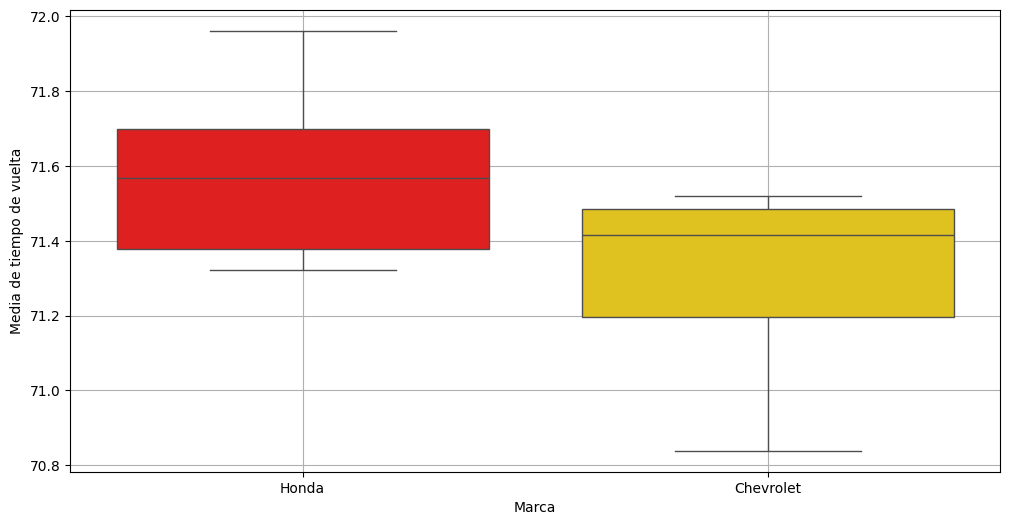

In [6]:

lista_posiciones = []
total_time_mean = sum(list(mean_global_time.values()))
for piloto in pilot_names:
    marca = list(conductores["Vehiculo marca"][conductores["Conductores"] == piloto])
    pilot_times = sum(list(mapa_piloto_global(concated_dataframes, piloto, diccionario_curvas_indices, cont=False).values())[:-3])
    dt_total = total_time_mean - pilot_times
    dt_calculado = (dt_total / total_time_mean) * 100
    lista_posiciones.append((marca[0], pilot_times))

df_posiciones = pd.DataFrame(lista_posiciones, columns=['Marca', 'Media de tiempo de vuelta'])
colores = {'Honda': 'red', 'Chevrolet': 'gold'}
plt.figure(figsize=(12, 6))
boxplot = sns.boxplot(x='Marca', y='Media de tiempo de vuelta', data=df_posiciones, showfliers=False, palette=colores)
plt.grid(True)
for patch in boxplot.artists:
    r, g, b, a = patch.get_facecolor
    if patch.get_xdata()[0] == 0:  # Honda
        patch.set_facecolor('red')
    elif patch.get_xdata()[0] == 1:  # Chevrolet
        patch.set_facecolor('gold')

plt.show()


Este boxplot representa la media de tiempo de todos los pilotos respecto a su marca, tomando en consideracion solo el rendimiento puro por vuelta (en otras palabras, descartamos las metricas que esten relacionadas a estrategia de equipo, factores externos y nos centramos solo en la media de los tiempos de vuelta). Tambien se descartan los tiempos de PI to PO, PO to SF y SF to PI.

Es claramente apreciable que los pilotos que utilizan motores Chevrolet tienen una media que representa un mejor rendimiento tanto en los valores mas bajos de tiempo, como en la media general de pilotos.

Se descarto la media de el piloto Rasmussen ya que este solo completo 14 vueltas, en las cuales tuvo un rendimiento muy por debajo del resto, esto generaria un outlier muy separado del resto de pilotos.

### **Mapa**

C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\1075933059.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

C:\Users\Franco-SEC\AppData\Local\Temp\ipykernel_18164\1075933059.py:17: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



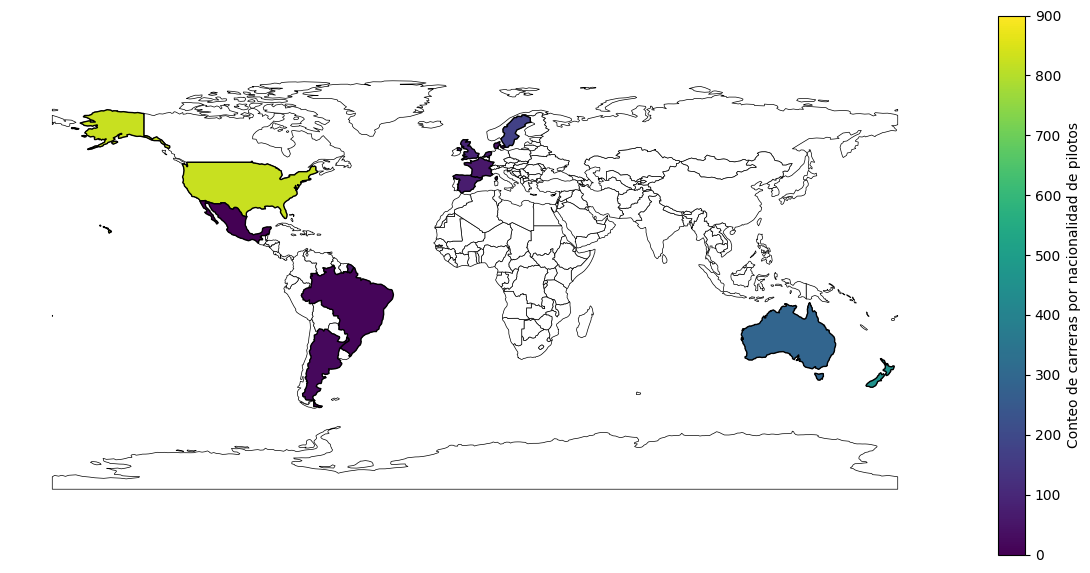

In [7]:
conductores_por_pais = conductores.groupby('Nacionalidad')['Carreras'].sum().reset_index()

# Carga el mapa mundial
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Une el DataFrame con el mapa mundial
world = world.merge(conductores_por_pais, left_on='name', right_on='Nacionalidad', how='left')

# Reemplaza los valores NaN con 0 para los países que no están en tu DataFrame
world['Carreras'] = world['Carreras']

# Crea el mapa base
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# Genera el mapa de calor
world.plot(ax=ax, color='white', linewidths=0.2)
world.plot(column="name",ax=ax,color="white",linewidths=0.5,edgecolor="black")
world.plot(column='Carreras', ax=ax, legend=True,
           legend_kwds={'label': "Conteo de carreras por nacionalidad de pilotos",
                        'orientation': "vertical"}, cmap="viridis", vmin=0, vmax=900, edgecolor='black')
ax.axis("off")


plt.show()

Este mapa resume de forma visual la participacion en carreras respecto a cada pais (en otras palabras, la sumatoria de cantidad de carreras corridas por pilotos de cada pais); es notable que, entre los pilotos que corren actualmente, existe una participacion mayoritaria de pilotos de Estados Unidos, seguido de Nueva Zelanda y Australia. Esto se debe principalmente a que la categoria historicamente fue mas popular en dichos paises.

Tambien apreciamos, en menor medida, participaciones latinoamericana y europea, con pilotos como por ejemplo Agustin Canapino (Argentina), Patricio O´Ward (Mexico) y Alex Palou (España).

